In [1]:
import tensorflow as tf

print(tf.__version__)

from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from tensorflow.keras.optimizers            import SGD, RMSprop, Adam, Adagrad, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import random
# import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import scipy
import skimage
from skimage.transform import resize
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

2023-09-16 15:31:29.272654: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-16 15:31:32.588494: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-16 15:31:32.588712: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

2.11.0


In [2]:
# !git clone https://github.com/EricMartinezIllamola/asl-alphabet.git

In [3]:
# !pip install split-folders 

In [4]:
# import splitfolders
# import os

In [5]:
# path = "asl-alphabet/asl-alphabet"

# splitfolders.ratio(path, seed=777, output="Train-Validation-Test-Dataset", ratio=(0.6, 0.2, 0.2))

In [6]:
train_path = "Train-Validation-Test-Dataset/train"
val_path = "Train-Validation-Test-Dataset/val"
test_path = "Train-Validation-Test-Dataset/test"

In [7]:
tf.config.experimental.list_physical_devices()

2023-09-16 15:31:36.703997: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-16 15:31:36.718383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-16 15:31:36.721182: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
tf.test.is_built_with_cuda()

True

In [9]:
from tensorflow.keras.preprocessing.image   import ImageDataGenerator

##Clasificamos las imagenes
bs = 64 #bach size
k = 2
# Generador de imágenes de entrenamiento.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=(0.3),
        zoom_range=(0.3),
        width_shift_range=(0.2),
        height_shift_range=(0.2),
        # validation_split = 0.2,
        brightness_range=(0.05,0.85),
        horizontal_flip=False)

# Carga de imágenes al generador de entrenamiento desde directorio.
train_generator = train_datagen.flow_from_directory(
        train_path,
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'training',
        batch_size=bs)

valid_generator = train_datagen.flow_from_directory(
        val_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

test_generator = train_datagen.flow_from_directory(
        test_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

Found 44695 images belonging to 24 classes.
Found 14892 images belonging to 24 classes.
Found 14921 images belonging to 24 classes.


In [10]:
#Visualizamos la estructura del modelo que vamos a utilizar
model = tf.keras.applications.VGG19()
model.summary()
print(len(model.layers))

2023-09-16 15:31:43.571976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-16 15:31:43.573155: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-16 15:31:43.576647: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-16 15:31:43.579330: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
##DEFINIMOS EL MODELO
num_classes = 24
epochs = 25

# VGG19
# Importamos el modelo que queremos utilizar con los argumentos que queremos
VGG19_model = tf.keras.applications.VGG19(input_shape=(28*k,28*k,3),
                                          include_top=False,
                                          weights='imagenet')

print(len(VGG19_model.layers))
#Congelamos  las 6 primeras caps del modelo para proceder a entrenar las demás
for layer in VGG19_model.layers[:6]:
  layer.trainable = False

# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)

# Continuamos añadiendo más capas que sí serán entrenadas...
from tensorflow.keras import regularizers
model.add(Flatten())
model.add(Dense(1024, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation = 'softmax'))

22


In [12]:
## EJECUCION DEL MODELO
# with tf.device("/CPU:0"):
# with tf.device("/GPU:0"):
model.compile(loss="categorical_crossentropy", 
              optimizer= SGD(learning_rate=0.001),
              metrics=['accuracy'])

#Agregamos un callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='model-01', verbose=1, save_best_only=True,
                               monitor = 'accuracy', mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.000001)

history= model.fit(train_generator, callbacks = [reduce_lr, checkpointer], epochs=epochs)

Epoch 1/25


2023-09-16 15:31:49.606824: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2023-09-16 15:31:52.169102: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f411fbf7c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-16 15:31:52.169160: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-09-16 15:31:52.252931: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


699/699 [==============================] - ETA: 0s - loss: 9.6077 - accuracy: 0.1509
Epoch 1: accuracy improved from -inf to 0.15089, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


699/699 [==============================] - 99s 132ms/step - loss: 9.6077 - accuracy: 0.1509 - lr: 0.0010
Epoch 2/25
699/699 [==============================] - ETA: 0s - loss: 8.0329 - accuracy: 0.5424
Epoch 2: accuracy improved from 0.15089 to 0.54243, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


699/699 [==============================] - 91s 131ms/step - loss: 8.0329 - accuracy: 0.5424 - lr: 0.0010
Epoch 3/25
699/699 [==============================] - ETA: 0s - loss: 7.2302 - accuracy: 0.7293
Epoch 3: accuracy improved from 0.54243 to 0.72932, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


699/699 [==============================] - 91s 130ms/step - loss: 7.2302 - accuracy: 0.7293 - lr: 0.0010
Epoch 4/25
699/699 [==============================] - ETA: 0s - loss: 6.8249 - accuracy: 0.8035
Epoch 4: accuracy improved from 0.72932 to 0.80349, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


699/699 [==============================] - 92s 131ms/step - loss: 6.8249 - accuracy: 0.8035 - lr: 0.0010
Epoch 5/25
699/699 [==============================] - ETA: 0s - loss: 6.5350 - accuracy: 0.8412
Epoch 5: accuracy improved from 0.80349 to 0.84121, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


699/699 [==============================] - 90s 129ms/step - loss: 6.5350 - accuracy: 0.8412 - lr: 0.0010
Epoch 6/25
699/699 [==============================] - ETA: 0s - loss: 6.2915 - accuracy: 0.8639
Epoch 6: accuracy improved from 0.84121 to 0.86388, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


699/699 [==============================] - 91s 131ms/step - loss: 6.2915 - accuracy: 0.8639 - lr: 0.0010
Epoch 7/25
699/699 [==============================] - ETA: 0s - loss: 6.0744 - accuracy: 0.8829
Epoch 7: accuracy improved from 0.86388 to 0.88287, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


699/699 [==============================] - 90s 129ms/step - loss: 6.0744 - accuracy: 0.8829 - lr: 0.0010
Epoch 8/25
699/699 [==============================] - ETA: 0s - loss: 5.8761 - accuracy: 0.8958
Epoch 8: accuracy improved from 0.88287 to 0.89585, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


699/699 [==============================] - 90s 129ms/step - loss: 5.8761 - accuracy: 0.8958 - lr: 0.0010
Epoch 9/25
699/699 [==============================] - ETA: 0s - loss: 5.6981 - accuracy: 0.9042
Epoch 9: accuracy improved from 0.89585 to 0.90420, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


699/699 [==============================] - 90s 129ms/step - loss: 5.6981 - accuracy: 0.9042 - lr: 0.0010
Epoch 10/25
699/699 [==============================] - ETA: 0s - loss: 5.5259 - accuracy: 0.9127
Epoch 10: accuracy improved from 0.90420 to 0.91270, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


699/699 [==============================] - 90s 129ms/step - loss: 5.5259 - accuracy: 0.9127 - lr: 0.0010
Epoch 11/25
699/699 [==============================] - ETA: 0s - loss: 5.3594 - accuracy: 0.9194
Epoch 11: accuracy improved from 0.91270 to 0.91939, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


699/699 [==============================] - 91s 130ms/step - loss: 5.3594 - accuracy: 0.9194 - lr: 0.0010
Epoch 12/25
699/699 [==============================] - ETA: 0s - loss: 5.2004 - accuracy: 0.9245
Epoch 12: accuracy improved from 0.91939 to 0.92451, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


699/699 [==============================] - 90s 129ms/step - loss: 5.2004 - accuracy: 0.9245 - lr: 0.0010
Epoch 13/25
699/699 [==============================] - ETA: 0s - loss: 5.0468 - accuracy: 0.9314
Epoch 13: accuracy improved from 0.92451 to 0.93140, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


699/699 [==============================] - 90s 129ms/step - loss: 5.0468 - accuracy: 0.9314 - lr: 0.0010
Epoch 14/25
699/699 [==============================] - ETA: 0s - loss: 4.9055 - accuracy: 0.9333
Epoch 14: accuracy improved from 0.93140 to 0.93328, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


699/699 [==============================] - 89s 128ms/step - loss: 4.9055 - accuracy: 0.9333 - lr: 0.0010
Epoch 15/25
699/699 [==============================] - ETA: 0s - loss: 4.7675 - accuracy: 0.9364
Epoch 15: accuracy improved from 0.93328 to 0.93639, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


699/699 [==============================] - 91s 130ms/step - loss: 4.7675 - accuracy: 0.9364 - lr: 0.0010
Epoch 16/25
699/699 [==============================] - ETA: 0s - loss: 4.6297 - accuracy: 0.9410
Epoch 16: accuracy improved from 0.93639 to 0.94104, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


699/699 [==============================] - 90s 129ms/step - loss: 4.6297 - accuracy: 0.9410 - lr: 0.0010
Epoch 17/25
699/699 [==============================] - ETA: 0s - loss: 4.4985 - accuracy: 0.9442
Epoch 17: accuracy improved from 0.94104 to 0.94422, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


699/699 [==============================] - 89s 128ms/step - loss: 4.4985 - accuracy: 0.9442 - lr: 0.0010
Epoch 18/25
699/699 [==============================] - ETA: 0s - loss: 4.3769 - accuracy: 0.9438
Epoch 18: accuracy did not improve from 0.94422
699/699 [==============================] - 85s 122ms/step - loss: 4.3769 - accuracy: 0.9438 - lr: 0.0010
Epoch 19/25
699/699 [==============================] - ETA: 0s - loss: 4.2480 - accuracy: 0.9480
Epoch 19: accuracy improved from 0.94422 to 0.94798, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


699/699 [==============================] - 89s 128ms/step - loss: 4.2480 - accuracy: 0.9480 - lr: 0.0010
Epoch 20/25
699/699 [==============================] - ETA: 0s - loss: 4.1295 - accuracy: 0.9506
Epoch 20: accuracy improved from 0.94798 to 0.95062, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


699/699 [==============================] - 89s 128ms/step - loss: 4.1295 - accuracy: 0.9506 - lr: 0.0010
Epoch 21/25
699/699 [==============================] - ETA: 0s - loss: 4.0199 - accuracy: 0.9505
Epoch 21: accuracy did not improve from 0.95062
699/699 [==============================] - 84s 121ms/step - loss: 4.0199 - accuracy: 0.9505 - lr: 0.0010
Epoch 22/25
699/699 [==============================] - ETA: 0s - loss: 3.9038 - accuracy: 0.9545
Epoch 22: accuracy improved from 0.95062 to 0.95451, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


699/699 [==============================] - 90s 129ms/step - loss: 3.9038 - accuracy: 0.9545 - lr: 0.0010
Epoch 23/25
699/699 [==============================] - ETA: 0s - loss: 3.7954 - accuracy: 0.9552
Epoch 23: accuracy improved from 0.95451 to 0.95521, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


699/699 [==============================] - 89s 127ms/step - loss: 3.7954 - accuracy: 0.9552 - lr: 0.0010
Epoch 24/25
699/699 [==============================] - ETA: 0s - loss: 3.6922 - accuracy: 0.9571
Epoch 24: accuracy improved from 0.95521 to 0.95711, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


699/699 [==============================] - 89s 127ms/step - loss: 3.6922 - accuracy: 0.9571 - lr: 0.0010
Epoch 25/25
699/699 [==============================] - ETA: 0s - loss: 3.5871 - accuracy: 0.9583
Epoch 25: accuracy improved from 0.95711 to 0.95827, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


699/699 [==============================] - 90s 128ms/step - loss: 3.5871 - accuracy: 0.9583 - lr: 0.0010


In [13]:
preds_test = model.predict(test_generator)

234/234 [==============================] - 29s 122ms/step


In [14]:
evaluate_test = model.evaluate(test_generator)

234/234 [==============================] - 29s 122ms/step - loss: 3.5462 - accuracy: 0.9586


In [15]:
evaluate_test

[3.5462260246276855, 0.9586488604545593]

In [16]:
y_preds_test = np.array([np.argmax(x) for x in preds_test])
y_preds_test

array([ 5,  0, 11, ..., 23, 23, 23])

In [17]:
y_real_test = test_generator.classes
y_real_test

array([ 0,  0,  0, ..., 23, 23, 23], dtype=int32)

In [18]:
accuracy_test = accuracy_score(y_real_test, y_preds_test)
accuracy_test

0.9593861001273373

In [19]:
cm_test = confusion_matrix(y_real_test, y_preds_test)
cm_test

array([[599,   0,   0,   0,   3,   3,   0,   0,   2,   0,   0,   7,   1,
          0,   0,   0,   0,   2,   3,   0,   0,   0,   0,   0],
       [  1, 594,   2,   1,   7,   0,   0,   1,   3,   2,   0,   3,   1,
          0,   0,   0,   5,   1,   0,   1,   0,   0,   1,   0],
       [  3,   1, 621,   0,   0,   1,   0,   0,   2,   0,   1,   2,   0,
          1,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   2,   1, 599,   0,   0,   0,   0,   6,   0,   0,   0,   0,
         11,   0,   0,   0,   0,   0,   3,   0,   0,   0,   0],
       [  2,   6,   0,   1, 584,   0,   0,   0,   9,   0,   0,   1,   6,
          1,   0,   0,   2,  17,   3,   0,   0,   0,   4,   1],
       [  0,   0,   2,   0,   3, 599,   1,   0,   4,   1,   0,   0,   4,
          0,   0,   0,   2,   2,   1,   0,   2,   1,   0,   2],
       [  0,   0,   0,   0,   0,   0, 605,   9,   1,   0,   0,   0,   0,
          0,   2,   0,   1,   3,   0,   0,   0,   0,   0,   2],
       [  0,   0,   0,   0,   0,   0,   5

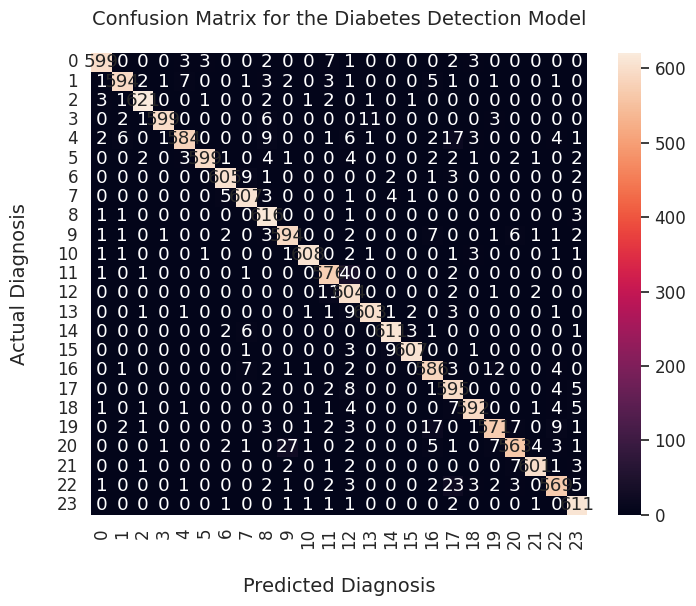

In [20]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_test, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()

In [21]:
preds_val = model.predict(valid_generator)

233/233 [==============================] - 29s 123ms/step


In [22]:
evaluate_val = model.evaluate(valid_generator)

233/233 [==============================] - 28s 119ms/step - loss: 3.5285 - accuracy: 0.9620


In [23]:
evaluate_val

[3.5285325050354004, 0.9619930386543274]

In [24]:
y_preds_val = np.array([np.argmax(x) for x in preds_val])
y_preds_val

array([ 0,  0, 12, ..., 23, 23, 23])

In [25]:
y_real_val = valid_generator.classes
y_real_val

array([ 0,  0,  0, ..., 23, 23, 23], dtype=int32)

In [26]:
accuracy_val = accuracy_score(y_real_val, y_preds_val)
accuracy_val

0.9638732205210852

In [27]:
cm_val = confusion_matrix(y_real_val, y_preds_val)
cm_val

array([[592,   1,   1,   0,   3,   1,   0,   0,   0,   0,   0,   6,   3,
          0,   0,   0,   0,   1,  10,   0,   0,   0,   0,   0],
       [  1, 599,   2,   0,   1,   1,   0,   0,   7,   0,   0,   6,   0,
          0,   0,   0,   3,   0,   0,   1,   0,   0,   0,   0],
       [  3,   0, 625,   0,   1,   0,   0,   0,   1,   0,   0,   0,   0,
          1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1],
       [  1,   3,   2, 599,   3,   1,   0,   0,   4,   0,   0,   0,   1,
          6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   5,   1,   0, 577,   0,   0,   0,  19,   0,   1,   7,   3,
          2,   1,   0,   1,  16,   1,   0,   0,   0,   3,   0],
       [  0,   0,   2,   0,   0, 600,   4,   1,   8,   3,   0,   0,   0,
          0,   0,   0,   1,   0,   2,   0,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0, 597,  16,   2,   0,   0,   0,   3,
          0,   3,   0,   0,   1,   0,   0,   0,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0,   6

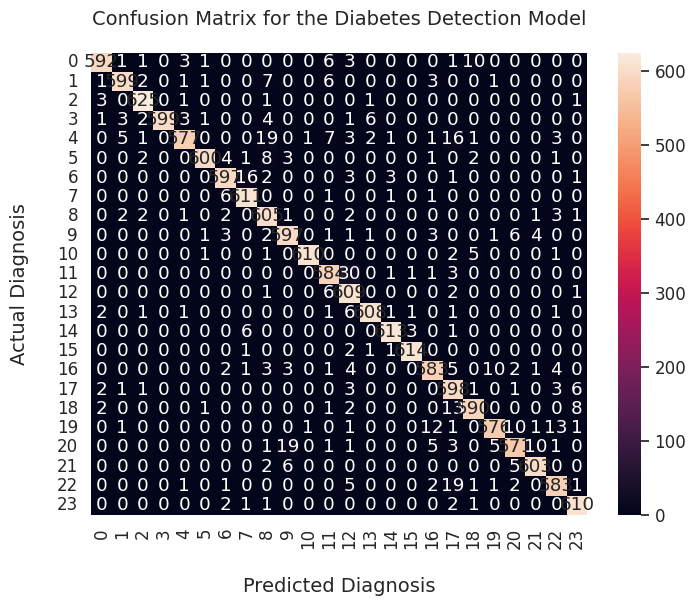

In [28]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_val, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()